<font size = 40 color=darkgreen>Dutch Rental Prices</font><br>
*Both my friends and myself have often asked the question, 'How much rent could I charge for my apartment?' The question becomes very complex as we start assuming that location, size, amenities, furnished, and many more attributes need to be considered when deciding on a rental price. My goal for this project is to build a model that will weigh all the attributes available using data from a popular rental website in the Netherlands, Kamernet. <BR>  
*Creating a regression model to predict the rental prices in the Netherlands using data from kamernet.nl*<br>
**Steps:**<br>
1. Importing libraries and reading data
2. EDA and re-shaping data for ML pre-processing 
3. PyCaret setup
4. Adjust base data, repeat compare and create steps

# <font color=teal>Import data</font>

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# ML libraries
import pycaret.regression as py
from pycaret.regression import *

# Options for pandas
pd.options.display.max_columns
pd.options.display.max_rows = 30

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno
import chart_studio.plotly as pl
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

In [2]:
# Reading json data from Kamernet

#Git
source = 'https://github.com/michael-william/Netherlands-Rental-Prices/raw/master/properties-trim.json'
df=pd.read_json(source, lines=True)


# <font color=teal>EDA and reshaping data</font>

> **<font color=brown>Overview</font>**
> 1. Dropping non-needed columns
> 2. Missing values
> 3. Cardinality of categorical values

In [3]:
# Creating copy of main df
data = df

In [4]:
# Viewing first 2 lines of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12830 entries, 0 to 12829
Data columns (total 61 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   _id                          12830 non-null  object 
 1   externalId                   12830 non-null  object 
 2   areaRaw                      12830 non-null  object 
 3   areaSqm                      12830 non-null  int64  
 4   city                         12830 non-null  object 
 5   coverImageUrl                12830 non-null  object 
 6   crawlStatus                  12830 non-null  object 
 7   crawledAt                    12830 non-null  object 
 8   datesPublished               12830 non-null  object 
 9   firstSeenAt                  12830 non-null  object 
 10  furnish                      12830 non-null  object 
 11  lastSeenAt                   12830 non-null  object 
 12  latitude                     12830 non-null  float64
 13  longitude       

## <font color=brown>Dropping columns with +50% nulls</font>

In [5]:
data = data.drop(['deposit', 'additionalCostsRaw', 'additionalCosts', 'registrationCost'], axis=1)

## **<font color=brown>Dropping columns</font>**

In [6]:
# inspection of the following columns shows them to be irrelevant or repeats of other columns 
data = data.drop(['_id','externalId','coverImageUrl','crawlStatus', 'crawledAt', 'datesPublished', 'url', 'source',
              'descriptionNonTranslated','descriptionNonTranslatedRaw','descriptionTranslated',
              'descriptionTranslatedRaw', 'detailsCrawledAt', 'pageDescription', 'pageTitle','userDisplayName',
              'userId','firstSeenAt','lastSeenAt','rentDetail','userLastLoggedOn','userMemberSince','userPhotoUrl', 
              'areaRaw','rentRaw','registrationCostRaw','depositRaw',"matchAge","matchAgeBackup",
              "matchCapacity","matchGender","matchGenderBackup","matchLanguages","matchStatus","matchStatusBackup", 
              'postedAgo', 'rawAvailability', 'gender', 'title', 'postalCode','isRoomActive', 'city'], axis=1)

In [7]:
# converting 'roommates' feature to 'int' and creating a new binary feature called 'shared'
data['roommates'] = data.roommates.replace(to_replace='None', value=0)
data['roommates'] = data.roommates.replace(to_replace='More than 8', value=9)
data['roommates'] = data.roommates.replace(to_replace='Unknown', value=0)
data['roommates'] = data.roommates.replace(to_replace='nan', value=0)
data['roommates'] = data.roommates.fillna(0)
data['roommates'] = data.roommates.astype('int')
data['shared'] = [1 if x>"yes" else "no" for x in data.roommates]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12830 entries, 0 to 12829
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   areaSqm        12830 non-null  int64  
 1   furnish        12830 non-null  object 
 2   latitude       12830 non-null  float64
 3   longitude      12830 non-null  float64
 4   propertyType   12830 non-null  object 
 5   rent           12830 non-null  int64  
 6   energyLabel    12749 non-null  object 
 7   internet       12749 non-null  object 
 8   kitchen        12749 non-null  object 
 9   living         12749 non-null  object 
 10  pets           12749 non-null  object 
 11  roommates      12830 non-null  int64  
 12  shower         12749 non-null  object 
 13  smokingInside  12749 non-null  object 
 14  toilet         12749 non-null  object 
 15  shared         12830 non-null  int64  
dtypes: float64(2), int64(4), object(10)
memory usage: 1.6+ MB


In [9]:
# dropping rows with nulls to save on preprocessing time
data = data.dropna()

In [10]:
# viewing cardinality of remaining columns
data.nunique()

areaSqm           196
furnish             4
latitude         7991
longitude        8003
propertyType        5
rent              750
energyLabel         8
internet            3
kitchen             4
living              4
pets                3
roommates          10
shower              3
smokingInside       3
toilet              3
shared              2
dtype: int64

In [13]:
# dropping columns due to high cardinality and thinking that new 'shared' column will help supplement
data.drop(['roommates','energyLabel'], axis=1, inplace=True)

In [14]:
# dropping other columns to reduce feature size and final application input
data.drop(['internet', 'pets', 'smokingInside', ], inplace=True, axis=1)

# <font color=teal>PyCaret setup and model creation</font>

## **<font color=brown>Setup</font>**

In [15]:
# setting up pycaret with 'rent'as target
exp_clf = py.setup(data, target = 'rent')

 
Setup Succesfully Completed!


,Description,Value
0,session_id,5861
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(12749, 11)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## **<font color=brown>Comparing models</font>**

In [16]:
py.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,116.391500,40265.540100,198.703800,0.806200,0.345600,1.159400
1,Light Gradient Boosting Machine,116.404600,41493.550100,202.019000,0.801000,0.343800,1.131400
2,Random Forest,108.875400,43050.971100,205.399300,0.794000,0.334300,0.973200
3,Extra Trees Regressor,110.154600,44981.884600,211.164600,0.783100,0.331600,0.893500
4,Extreme Gradient Boosting,127.238400,46456.740800,213.817700,0.776600,0.359100,1.208100
5,Gradient Boosting Regressor,127.586200,47329.289800,215.620800,0.771900,0.359000,1.204000
6,K Neighbors Regressor,153.081900,71848.205500,266.704600,0.658700,0.390900,1.292400
7,Decision Tree,139.463600,80223.555500,279.327300,0.619500,0.430700,0.920200
8,Bayesian Ridge,171.178900,80536.135900,282.229000,0.618100,0.427600,1.354300
9,Linear Regression,171.294300,80536.855800,282.236500,0.618000,0.429600,1.353600


## **<font color=brown>Creating model</font>**

In [17]:
# the Random Forrest had the lowest MAE which is most relevant for this project
rf = py.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,106.4793,36242.2172,190.3739,0.8077,0.3064,0.7296
1,109.5858,42059.4862,205.0841,0.8450,0.2352,0.1744
2,106.7214,37067.4396,192.5291,0.8269,0.3283,0.7251
3,119.4900,64040.8296,253.0629,0.7506,0.4285,1.6758
4,105.3030,35754.2478,189.0879,0.7847,0.4227,1.4497
5,112.9726,48366.4062,219.9236,0.7158,0.4111,2.4656
6,111.0865,69524.2590,263.6745,0.6803,0.3059,0.5752
7,104.6658,35140.7318,187.4586,0.8428,0.3357,0.7312
8,107.7356,33397.0432,182.7486,0.8311,0.2383,0.1823
9,104.7139,28917.0499,170.0501,0.8554,0.3307,1.0232


In [18]:
# creating a 'bagged' version of the model to see if the results are boosted
rf_bagged = py.ensemble_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,108.2500,34882.7173,186.7692,0.8149,0.3056,0.7159
1,112.0243,41152.1529,202.8599,0.8483,0.2363,0.1797
2,108.5070,34430.2815,185.5540,0.8392,0.3386,0.8813
3,121.1184,58950.1415,242.7965,0.7705,0.4318,1.7805
4,106.0746,30298.6333,174.0650,0.8176,0.4304,1.7055
5,113.3562,46368.2551,215.3329,0.7275,0.4121,2.5748
6,110.9038,66625.9160,258.1200,0.6937,0.3028,0.5738
7,105.0071,33432.8485,182.8465,0.8505,0.3388,0.7892
8,109.4236,31914.7229,178.6469,0.8386,0.2392,0.1878
9,107.1616,29767.4083,172.5323,0.8512,0.3356,1.0975


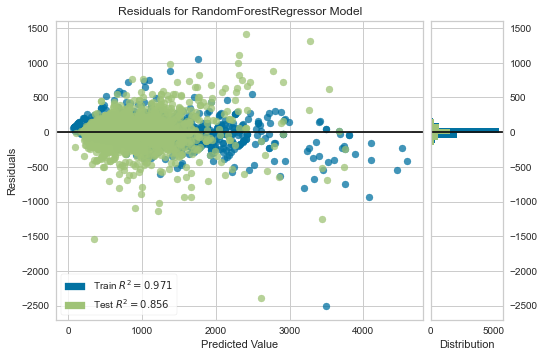

In [21]:
# analyzing residuals of the model vs the predicted value
py.plot_model(rf)

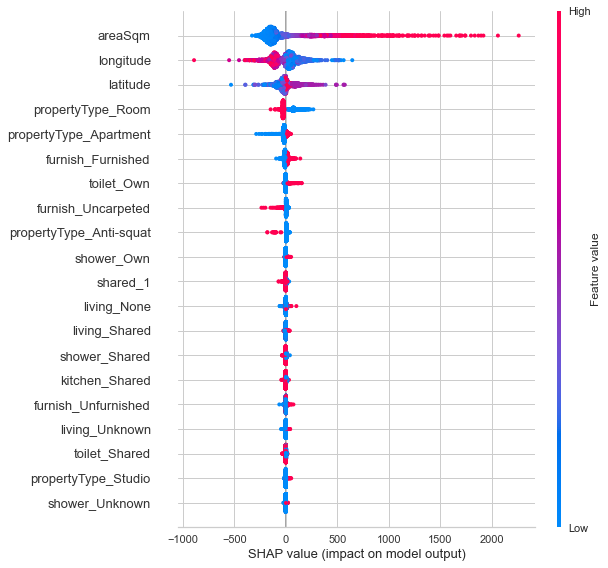

In [23]:
# viewing the impact of features on the model
py.interpret_model(rf)

# <font color=teal>Adjust base data and re-run</font>

## **<font color=brown>Drop low importance features</font>**

In [47]:
# new setup with low importance feature columns removed
clf2 = py.setup(data, target='rent', ignore_features=['toilet','shower', 'living', 'kitchen'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,3037
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(12749, 11)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## **<font color=brown>Compare models</font>**

In [25]:
# comparing models of new setup
py.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,115.969300,39743.354300,197.083100,0.808100,0.320500,0.805100
1,Light Gradient Boosting Machine,115.850300,40652.696800,199.797000,0.802900,0.318400,0.769100
2,Random Forest,108.511900,41153.814100,201.166300,0.800300,0.313500,0.718200
3,Extra Trees Regressor,109.084400,43998.741000,207.118600,0.788200,0.319300,0.719400
4,Gradient Boosting Regressor,126.152500,44764.103400,210.036700,0.782500,0.332000,0.853100
5,Extreme Gradient Boosting,126.314600,44771.602700,210.104200,0.782200,0.332400,0.854300
6,K Neighbors Regressor,146.466700,64788.649600,253.116400,0.684600,0.356800,0.911600
7,Decision Tree,133.871300,67434.323200,257.935900,0.670600,0.415600,0.687400
8,Linear Regression,164.556100,73596.170600,269.542900,0.642100,0.397200,0.984600
9,Ridge Regression,164.537700,73595.387700,269.540500,0.642100,0.395600,0.984600


## **<font color=brown>Create models</font>**

In [48]:
# the Random Forrest model was again the best with some improved metrics
rf2 = py.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,104.0212,32043.0116,179.0056,0.8345,0.3322,1.0703
1,106.4219,37258.2340,193.0239,0.7946,0.2637,0.2044
2,114.5902,74920.3910,273.7159,0.7081,0.3472,1.7147
3,104.0942,33847.7228,183.9775,0.8328,0.3448,1.1388
4,101.6279,28775.8801,169.6345,0.8567,0.2967,0.6669
5,103.6353,35542.1762,188.5263,0.8489,0.2136,0.1574
6,110.0107,40799.8822,201.9898,0.7773,0.3509,0.7861
7,116.3619,48062.5429,219.2317,0.7458,0.3634,0.9311
8,115.4613,38884.2462,197.1909,0.8398,0.3940,1.4014
9,114.6087,38378.0654,195.9032,0.8091,0.2434,0.1816


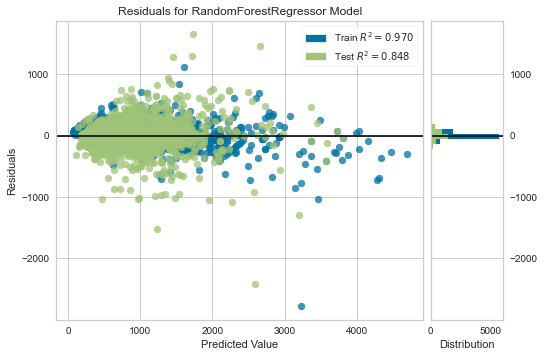

In [52]:
# viewing the residuals of the model vs the preidtced value
py.plot_model(rf2)

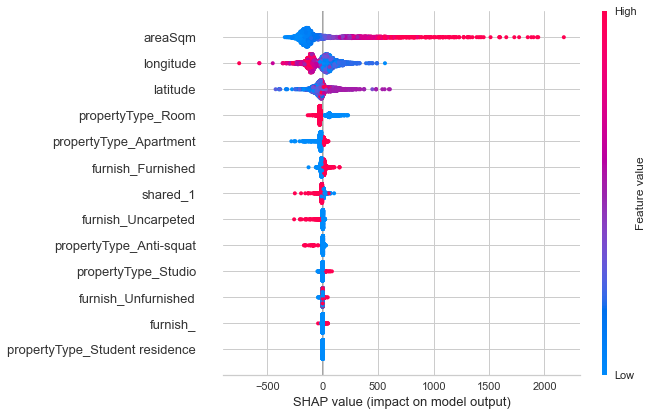

In [28]:
# viewing impact of feature on the model
py.interpret_model(rf2)

## **<font color=brown>Predict on hold-out set</font>**

In [49]:
# using the hold-out set from setup to predict rent with model
rf2_predict = py.predict_model(rf2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,99.4588,29650.0253,172.1918,0.8477,0.3133,0.7541


## **<font color=brown>Finalize and save model</font>**

In [50]:
# finalizing the model to adjust for over/under fitting
final_rf2 = py.finalize_model(rf2)
final_rf2

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=3037, verbose=0, warm_start=False)

In [51]:
# saving the model
py.save_model(final_rf2, "dutch_pycaret_rf")

Transformation Pipeline and Model Succesfully Saved


In [35]:
# saving the experiment
py.save_experiment("exp_dutch_pycaret_rf")

Experiment Succesfully Saved


In [46]:
# final dataframe
data.drop(['toilet', 'shower', 'living', 'kitchen'], axis=1).head()

,areaSqm,furnish,latitude,longitude,propertyType,rent,shared
0,14,Unfurnished,51.896601,4.514993,Room,500,yes
1,30,Furnished,52.370200,4.920721,Studio,950,no
2,11,Furnished,52.350880,4.854786,Room,1000,yes
3,16,Unfurnished,53.013494,6.561012,Room,290,yes
4,22,Unfurnished,51.932871,4.479732,Room,475,yes
